In [1]:
# System
import os

# Data processing
import numpy as np

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# All hyperparameters are listed in model.py you can change them there
import train
from model import *

%matplotlib inline

In [2]:
N_CELLS_HOR = 200
N_CELLS_VER = 250

In [3]:
celled_data = torch.load("Data/celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([9591, 1, 200, 250])


In [4]:
DEVICE_ID = 0
# torch.cuda.set_device(DEVICE_ID)
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
print (DEVICE)

cpu


### Создадим датасет

In [5]:
OBSERVED_DAYS = 64     # ~2 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

HEAVY_QUAKE_THRES = 3.5

In [6]:
freq_map = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)

In [7]:
class Dataset_RNN_Train (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[idx],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)
        



In [8]:
dataset_train = Dataset_RNN_Train (celled_data)

dataloader_train = DataLoader(dataset_train,
                              batch_size=1,
                              shuffle=False,
                              num_workers=0)


self.data : torch.Size([8591, 1, 200, 250])
size      : 8541


In [16]:
dataset_train[2312]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]]))

In [9]:
N_CYCLES = 10
QUEUE_LENGHT = 50
LEARNING_RATE = 0.0003
LR_DECAY = 10.
EARTHQUAKE_WEIGHT = 10000.

Done : 8500 / 8541


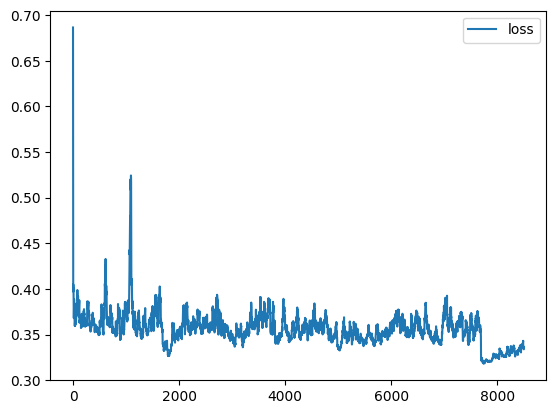

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 48, 3, 3]] is at version 8543; expected version 8542 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [10]:
torch.cuda.empty_cache()

RNN_cell = LSTMCell(freq_map,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    n_cells_hor       = N_CELLS_HOR,
                    n_cells_ver       = N_CELLS_VER,
                    device            = DEVICE)

torch.cuda.empty_cache()

train.train_RNN_full (RNN_cell,
                      DEVICE,
                      dataloader_train,
                      n_cycles=1,
                      learning_rate=LEARNING_RATE,
                      earthquake_weight=EARTHQUAKE_WEIGHT,
                      lr_decay=LR_DECAY)

torch.cuda.empty_cache()

train.train_RNN_part (RNN_cell,
                      DEVICE,
                      dataset_train,
                      n_cycles=N_CYCLES,
                      queue_lenght=QUEUE_LENGHT,
                      learning_rate=LEARNING_RATE,
                      earthquake_weight=EARTHQUAKE_WEIGHT,
                      lr_decay=LR_DECAY)

torch.cuda.empty_cache()

train.train_RNN_full (RNN_cell,
                      DEVICE,
                      dataloader_train,
                      n_cycles=1,
                      learning_rate=LEARNING_RATE,
                      earthquake_weight=EARTHQUAKE_WEIGHT,
                      lr_decay=LR_DECAY)

In [ ]:
if not os.path.exists("Model"):
    os.mkdir("Model")
torch.save(RNN_cell.state_dict(), "Model/state_dict")